In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ccxt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM

In [3]:
exchange = ccxt.binance()

# Obtener datos históricos
symbol = 'BTC/MXN'
timeframe = '1h'
since = exchange.parse8601('2023-10-01T00:00:00Z')
limit = 1000
ohlc = exchange.fetch_ohlcv(symbol, timeframe, since, limit)

In [12]:
# Convertir a DataFrame
df = pd.DataFrame(ohlc, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

print(df.head())

                          open       high        low      close    volume
timestamp                                                                
2024-05-29 15:00:00  1152513.0  1222880.0  1149898.0  1154680.0  0.178535
2024-05-29 16:00:00  1151976.0  1153714.0  1150730.0  1150730.0  0.016489
2024-05-29 17:00:00  1149953.0  1156310.0  1149953.0  1155403.0  0.001466
2024-05-29 18:00:00  1144952.0  1147208.0  1144952.0  1147208.0  0.038433
2024-05-29 19:00:00  1150475.0  1153626.0  1147208.0  1147208.0  0.020860


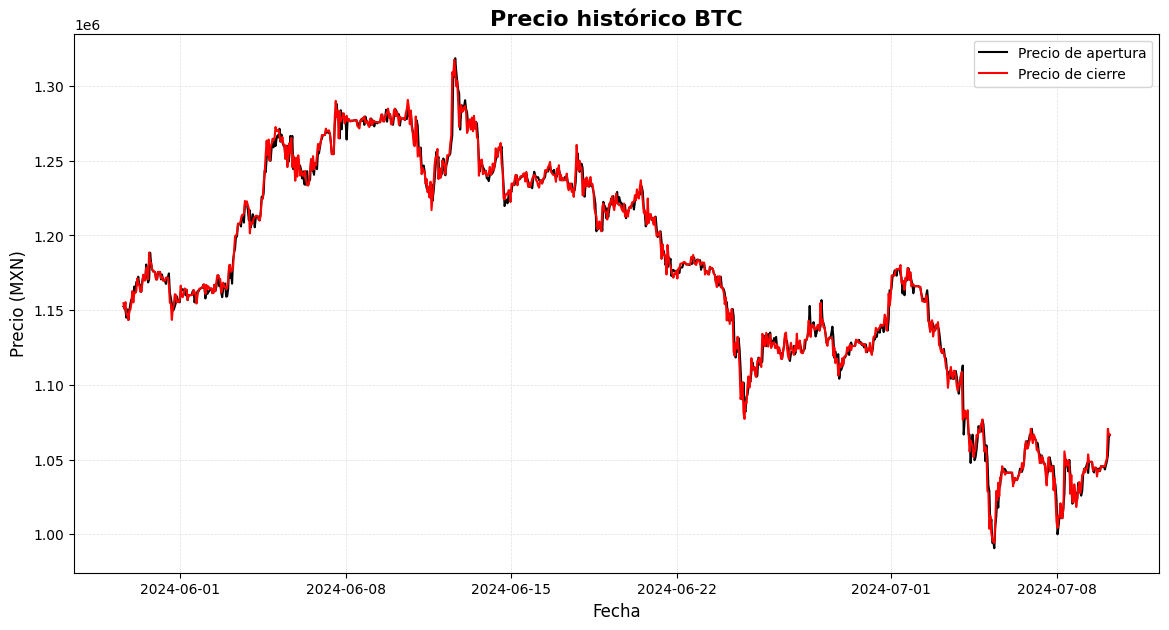

In [5]:
plt.figure(figsize=(14, 7))

# Precio de apertura
plt.plot(df.index, df["open"], label="Precio de apertura", color='black', linewidth=1.5)

# Precio de cierre
plt.plot(df.index, df["close"], label="Precio de cierre", color='red', linewidth=1.5)

plt.title("Precio histórico BTC", fontsize=16, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio (MXN)", fontsize=12)
plt.legend()
plt.grid(visible=True, color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [14]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['close']])
print(df_scaled[:5])

[[0.49618384]
 [0.48396843]
 [0.49841973]
 [0.47307661]
 [0.47307661]]


In [17]:
# Preparar los datos en secuencias
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i, 0])
    y.append(df_scaled[i, 0])
X, y = np.array(X), np.array(y)

# Transformar en un formato compatible con el modelo LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(X[0][:5])

[[0.49618384]
 [0.48396843]
 [0.49841973]
 [0.47307661]
 [0.47307661]]


In [8]:
# Construcción del modelo LSTM
model = Sequential()
model.add(Input(shape=(X.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1)) # Predicción de un solo valor

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# Entrenamiento del modelo
model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1577
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0047
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0017
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
Epoc

In [19]:
# Preparación de los datos para la predicción
test_data = df_scaled[-sequence_length:]
X_test = np.array([test_data])
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test[0][:5])

[[0.15462237]
 [0.15902611]
 [0.10904806]
 [0.13355311]
 [0.08714691]]


In [21]:
# Predicción
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
print("Precio predicho:", predicted_price[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Precio predicho: 1053795.4


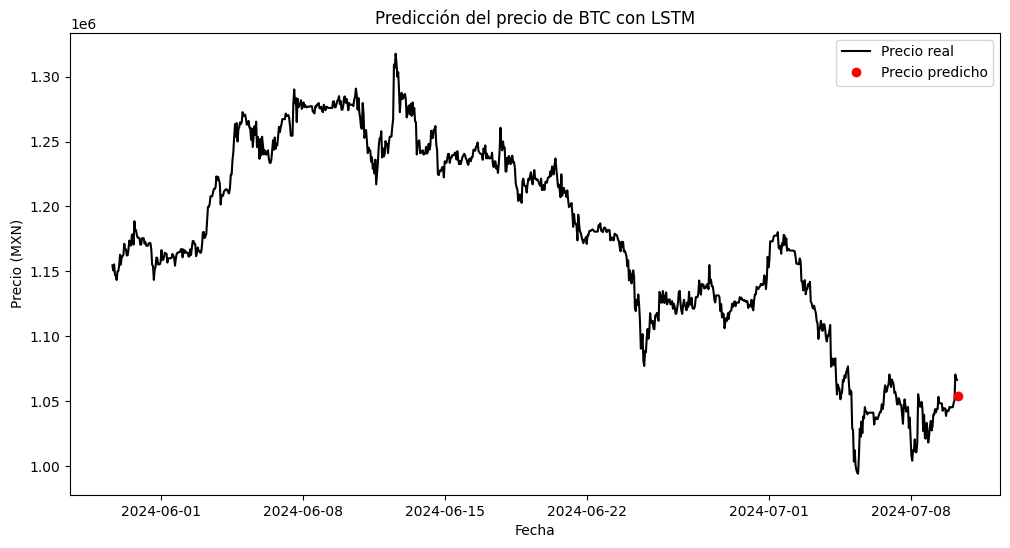

In [22]:
# Graficar el resultado
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], color='black', label='Precio real')
plt.plot(df.index[-1] + pd.DateOffset(hours=1), predicted_price[0][0], 'ro', label="Precio predicho")
plt.title("Predicción del precio de BTC con LSTM")
plt.xlabel("Fecha")
plt.ylabel("Precio (MXN)")
plt.legend()
plt.show()